In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rand_input = torch.tensor(data=torch.Tensor(1, 3, 80, 170), device=device, requires_grad=True)
print(rand_input.device)
print(device)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


cuda:0
cuda


In [0]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd #  gradien
import torch.nn.functional as F # Forward neural network

In [0]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h3>Use Cuda</h3>

In [0]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

<h2>Replay Buffer</h2>

In [0]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
      # deque: list-like container with fast appends and pops on either end
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        # np.expand_dims: Expand the shape of an array.
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

<h2>Cart Pole Environment</h2>

In [7]:
env_id = "CartPole-v0"
env = gym.make(env_id)
print(env.action_space)
print(env.action_space.n)
#position of cart, velocity of cart, angle of pole, rotation rate of pole
print(env.observation_space.shape[0])

Discrete(2)
2
4


<h2>Epsilon greedy exploration</h2>

In [0]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

#lambda : creation of anonymous functions
epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

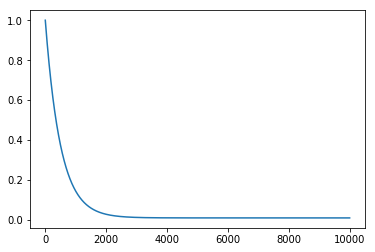

In [9]:
plt.plot([epsilon_by_frame(i) for i in range(10000)])

<h2>Deep Q Network</h2>

In [0]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        #Control on explotation and exploration
        #random between 0,1
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            #q_value.max(1)[1].data[0]
            action  = q_value.max(1)[1].item()
        else:
            # function to Get a random number in a range 2 (2 actions for this environment)
            action = random.randrange(env.action_space.n)
        return action

In [0]:
#DQN(4,2)
model = DQN(env.observation_space.shape[0], env.action_space.n)

if USE_CUDA:
    model = model.cuda()
    
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(1000)

Deep Q-network is a seminal piece of work to make the training of Q-learning more stable and more data-efficient, when the Q value is approximated with a nonlinear function. Two key ingredients are experience replay and a separately updated target network.

The main loss function looks like the following,

$$
\begin{aligned} Y\left(s, a, r, s^{\prime}\right)=r+\gamma \max _{a^{\prime}} Q_{\theta^{-}}\left(s^{\prime}, a^{\prime}\right) \\ \mathcal{L}(\theta)=\mathbb{E}_{\left(s, a, r, s^{\prime}\right) \sim U(D)}\left[\left(Y\left(s, a, r, s^{\prime}\right)-Q_{\theta}(s, a)\right)^{2}\right] \end{aligned}
$$

The Q network can be a multi-layer dense neural network, a convolutional network, or a recurrent network, depending on the problem.

<h2>Computing Temporal Difference Loss</h2>

In [0]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    print('action',len(action)) #action:32
    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = model(state)
    print('q_values',q_values.shape)
    next_q_values = model(next_state)
    print('next_q_values',next_q_values.shape)
    
    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    print('q_value',q_value.shape)
    next_q_value     = next_q_values.max(1)[0]
    print('next_q_value',next_q_value.shape)
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [0]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

<h2>Training</h2>

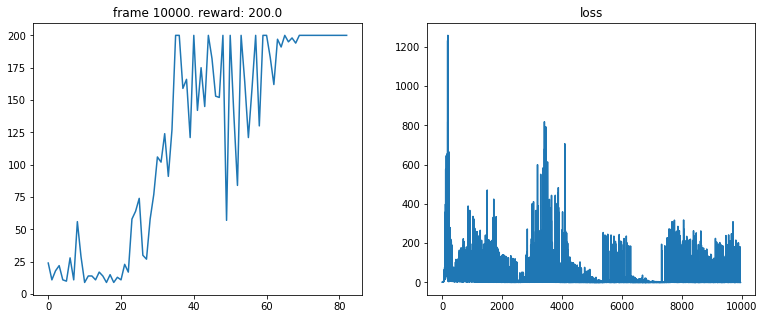

In [14]:
num_frames = 10000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    # Explotation and exploration
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    # Done is esqual to Flase-True
    #CartPole-v0 is considered "solved" when the agent obtains an average reward of 
    #at least 195.0 over 100 consecutive episodes
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size)
        # losses.append(loss.data[0])
        losses.append(loss.item())
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)

<p><hr></p>

<h1>Atari Environment</h1>

In [15]:
from google.colab import drive
drive.mount('/content/drive')
import os



path='/content/drive/My Drive/colab/images/'
os.chdir(path)
!pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/colab/images


In [0]:
from wrappers import make_atari, wrap_deepmind, wrap_pytorch

In [0]:
env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

In [0]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            #q_value.max(1)[1].data[0]
            action  = q_value.max(1)[1].item()
        else:
            action = random.randrange(env.action_space.n)
        return action

In [0]:
model = CnnDQN(env.observation_space.shape, env.action_space.n)

if USE_CUDA:
    model = model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=0.00001)

replay_initial = 10000
replay_buffer = ReplayBuffer(100000)

In [0]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 30000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

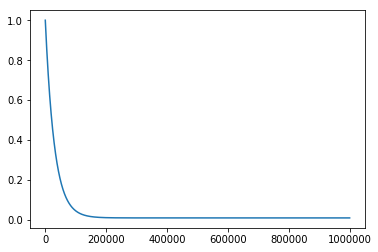

In [21]:
plt.plot([epsilon_by_frame(i) for i in range(1000000)])

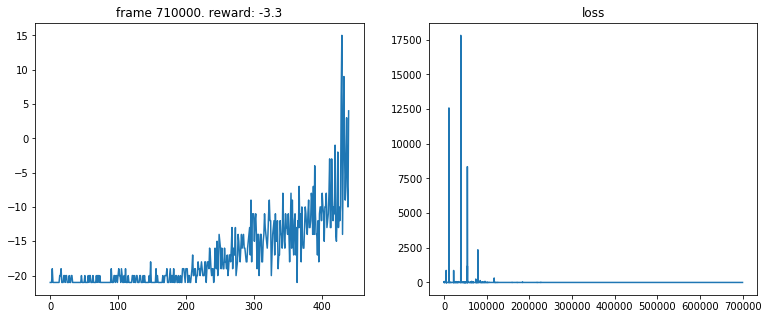

KeyboardInterrupt: ignored

In [22]:
num_frames = 1400000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > replay_initial:
        loss = compute_td_loss(batch_size)
        #losses.append(loss.data[0])
        losses.append(loss.item())
        
    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards, losses)
        
        #https://github.com/pytorch/pytorch/issues/7277

**Key concepts:**  
Experience Replay
Exploration/Exploitation
ε-Greedy Policy
Reward Clipping

**References:**  
1. https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html 
2. https://towardsdatascience.com/dqn-part-1-vanilla-deep-q-networks-6eb4a00febfb  
3. https://towardsdatascience.com/self-learning-ai-agents-part-ii-deep-q-learning-b5ac60c3f47  
4. https://medium.com/deep-math-machine-learning-ai/ch-13-deep-reinforcement-learning-deep-q-learning-and-policy-gradients-towards-agi-a2a0b611617e